In [2]:
# 필요한 라이브러리 정리하기

import os.path
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import perf_counter

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models

from sklearn.model_selection import train_test_split

In [33]:
import json

def read_labels(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)

    # 카테고리 id와 이름을 매핑한 딕셔너리를 생성
    categories = {category['id']: category['name'] for category in data['categories']}
    images = {image['id']: image['file_name'] for image in data['images']}

    # 이미지 파일명과 이미지 라벨을 매핑한 딕셔너리를 생성
    labels = {images[annotation['image_id']]: categories[annotation['category_id']] for annotation in data['annotations']}

    return labels
json_directory = 'noseprints/data/json' 
json_files = [os.path.join(json_directory, f) for f in os.listdir(json_directory) if f.endswith('.json')]

label_map = {}
for f in json_files:
    label_map.update(read_labels(f))

print(label_map)  # 라벨링 맵 확인

{'a001_1.jpg': 'a001', 'a001_2.jpg': 'a001', 'a001_3.jpg': 'a001', 'a001_4.jpg': 'a001', 'a001_5.jpg': 'a001', 'a001_6.jpg': 'a001', 'a001_7.jpg': 'a001', 'a001_8.jpg': 'a001', 'a001_9.jpg': 'a001', 'a001_10.jpg': 'a001', 'a001_11.jpg': 'a001', 'a002_1.jpg': 'a002', 'a002_2.jpg': 'a002', 'a002_3.jpg': 'a002', 'a002_4.jpg': 'a002', 'a002_5.jpg': 'a002', 'a002_6.jpg': 'a002', 'a003_1.jpg': 'a003', 'a003_2.jpg': 'a003', 'a003_3.jpg': 'a003', 'a003_4.jpg': 'a003', 'a003_5.jpg': 'a003', 'a003_6.jpg': 'a003', 'a003_7.jpg': 'a003', 'a003_8.jpg': 'a003', 'a003_9.jpg': 'a003', 'a004_1.jpg': 'a004', 'a004_2.jpg': 'a004', 'a004_3.jpg': 'a004', 'a004_4.jpg': 'a004', 'a004_5.jpg': 'a004', 'a005_1.jpg': 'a005', 'a005_2.jpg': 'a005', 'a006_1.jpg': 'a006', 'a006_2.jpg': 'a006', 'a006_3.jpg': 'a006', 'a006_4.jpg': 'a006', 'a006_5.jpg': 'a006', 'a006_6.jpg': 'a006', 'a006_7.jpg': 'a006', 'a007_1.jpg': 'a007', 'a007_2.jpg': 'a007', 'a007_3.jpg': 'a007', 'a008_1.jpg': 'a008', 'a008_10.jpg': 'a008', 'a008_

In [34]:
import pandas as pd

# 라벨맵을 데이터 프레임으로 변환
df = pd.DataFrame(list(label_map.items()), columns=['Image', 'Label'])

# 결과 출력
df.head()

Image Label
0  a001_1.jpg  a001
1  a001_2.jpg  a001
2  a001_3.jpg  a001
3  a001_4.jpg  a001
4  a001_5.jpg  a001

In [35]:
# 이미지 개수 및 클래스 개수(종류 수) 확인하기

labels = df['Label'].values.tolist()

label_list=[]
for i in labels:
    if i not in label_list:
        label_list.append(i)

print('The number of pictures:', df.shape[0])
print('The number of labels:', len(label_list))
print('Labels:', label_list)

The number of pictures: 124
The number of labels: 22
Labels: ['a001', 'a002', 'a003', 'a004', 'a005', 'a006', 'a007', 'a008', 'a009', 'a010', 'a011', 'a012', 'a013', 'a014', 'a015', 'a016', 'a017', 'a018', 'a019', 'a020', 'a022', 'a024']


In [48]:
df = pd.DataFrame(list(label_map.items()), columns=['Filepath', 'Label'])

# 이미지가 저장되어 있는 기본 디렉토리
base_dir = 'noseprints/data/images'

# Filepath 컬럼의 각 값을 절대 경로로 바꿉니다.
df['Filepath'] = df['Filepath'].apply(lambda x: os.path.join(base_dir, x).replace('\\', '/'))
df.head()

Filepath Label
0  noseprints/data/images/a001_1.jpg  a001
1  noseprints/data/images/a001_2.jpg  a001
2  noseprints/data/images/a001_3.jpg  a001
3  noseprints/data/images/a001_4.jpg  a001
4  noseprints/data/images/a001_5.jpg  a001

In [61]:
# train, test set으로 split(7대 3)
from sklearn.model_selection import StratifiedShuffleSplit # 모든 클래스의 비율을 동일하게 유지하면서 데이터를 나눠줌

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)

for train_index, test_index in sss.split(df['Filepath'], df['Label']):
    train_df = df.loc[train_index]
    test_df = df.loc[test_index]

In [62]:
# train_df를 9대 1로 split(train과 valid로)

train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=0)
train_df.shape, valid_df.shape

((77, 2), (9, 2))

In [79]:
# ImageDataGenerator 적용 과정(이미지 증강 과정)

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40, # 회전제한 각도 40도
                                   zoom_range=0.2, # 확대 축소 20%
                                   width_shift_range=0.2, # 좌우이동 20%
                                   height_shift_range=0.2, # 상하이동 20%
                                   shear_range=0.2, # 반시계방햐의 각도
                                   horizontal_flip=True, # 좌우 반전 True
                                   fill_mode="nearest")

valid_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    target_size=(128, 128),
                                                    batch_size=75,
                                                    class_mode='categorical'
                                                    )

validation_generator = valid_datagen.flow_from_dataframe(valid_df,
                                                     x_col='Filepath',
                                                     y_col='Label',
                                                     target_size=(128, 128),
                                                     batch_size=75,
                                                     class_mode='categorical'
                                                     )

Found 77 validated image filenames belonging to 22 classes.
Found 9 validated image filenames belonging to 8 classes.


In [80]:
# ResNet 모델 업로드
RN152_2 = tf.keras.applications.resnet_v2.ResNet152V2(weights="imagenet",
                                          include_top=False, 
                                          input_shape=(128, 128, 3))

RN152_2.trainable = False # 이미 학습된 가중치만을 사용

In [81]:
# 모델 제작
model = models.Sequential(name="ResNet152v2_RT")
model.add(RN152_2)

model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(22, activation = 'softmax'))

model.summary()

Model: "ResNet152v2_RT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 4, 4, 2048)        58331648  
                                                                 
 flatten_5 (Flatten)         (None, 32768)             0         
                                                                 
 dense_10 (Dense)            (None, 512)               16777728  
                                                                 
 dense_11 (Dense)            (None, 22)                11286     
                                                                 
Total params: 75,120,662
Trainable params: 16,789,014
Non-trainable params: 58,331,648
_________________________________________________________________


In [82]:
from tensorflow.keras import optimizers

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(learning_rate = 0.001),
              metrics = ['accuracy'])

In [86]:
    %%time

    history = model.fit(train_generator,
                        steps_per_epoch = train_df.shape[0]//75,
                        epochs = 50,
                        validation_data = validation_generator,
                        validation_steps = test_df.shape[0]//75)

Epoch 1/50
1/1 [==============================] - 7s 7s/step - loss: 2.7769 - accuracy: 0.4667
Epoch 2/50
1/1 [==============================] - 7s 7s/step - loss: 2.7657 - accuracy: 0.4400
Epoch 3/50
1/1 [==============================] - 7s 7s/step - loss: 1.7299 - accuracy: 0.5467
Epoch 4/50
1/1 [==============================] - 6s 6s/step - loss: 1.7242 - accuracy: 0.6133
Epoch 5/50
1/1 [==============================] - 1s 502ms/step - loss: 0.7165 - accuracy: 1.0000
Epoch 6/50
1/1 [==============================] - 0s 405ms/step - loss: 0.0461 - accuracy: 1.0000
Epoch 7/50
1/1 [==============================] - 0s 303ms/step - loss: 5.3695 - accuracy: 0.5000
Epoch 8/50
1/1 [==============================] - 0s 305ms/step - loss: 0.7814 - accuracy: 0.5000
Epoch 9/50
1/1 [==============================] - 6s 6s/step - loss: 1.0063 - accuracy: 0.7200
Epoch 10/50
1/1 [==============================] - 1s 551ms/step - loss: 0.0105 - accuracy: 1.0000
Epoch 11/50
1/1 [=================

In [87]:
# Test 데이터셋으로 성능 확인하기

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  x_col='Filepath',
                                                  y_col='Label',
                                                  target_size=(128, 128),
                                                  batch_size=75)
                                                  
loss, accuracy = model.evaluate(test_generator)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

Found 38 validated image filenames belonging to 22 classes.
1/1 [==============================] - 7s 7s/step - loss: 1.7764 - accuracy: 0.6316
Loss = 1.77637
Accuracy = 0.63158


1/1 [==============================] - 7s 7s/step


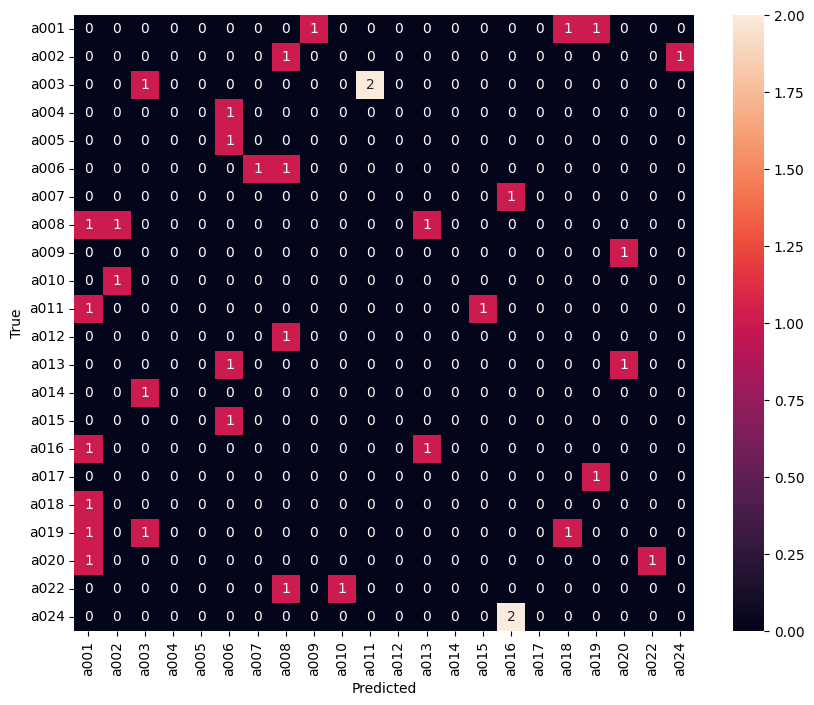

              precision    recall  f1-score   support

        a001       0.00      0.00      0.00         3
        a002       0.00      0.00      0.00         2
        a003       0.33      0.33      0.33         3
        a004       0.00      0.00      0.00         1
        a005       0.00      0.00      0.00         1
        a006       0.00      0.00      0.00         2
        a007       0.00      0.00      0.00         1
        a008       0.00      0.00      0.00         3
        a009       0.00      0.00      0.00         1
        a010       0.00      0.00      0.00         1
        a011       0.00      0.00      0.00         2
        a012       0.00      0.00      0.00         1
        a013       0.00      0.00      0.00         2
        a014       0.00      0.00      0.00         1
        a015       0.00      0.00      0.00         1
        a016       0.00      0.00      0.00         2
        a017       0.00      0.00      0.00         1
        a018       0.00    

c:\ProgramData\anaconda3\envs\dogs\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\dogs\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\dogs\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [88]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math

# 예측값 생성
test_generator.reset()
predictions = model.predict(test_generator, steps=math.ceil(test_generator.n/test_generator.batch_size), verbose=1) # 예측값 올림
predicted_classes = np.argmax(predictions, axis=1)

# 실제값 가져오기
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

# Confusion Matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Confusion Matrix 시각화
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

1/1 [==============================] - 3s 3s/step


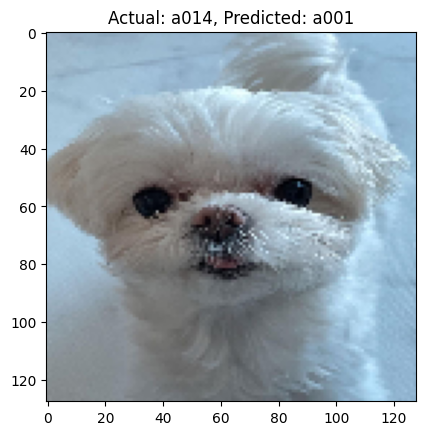

1/1 [==============================] - 0s 185ms/step


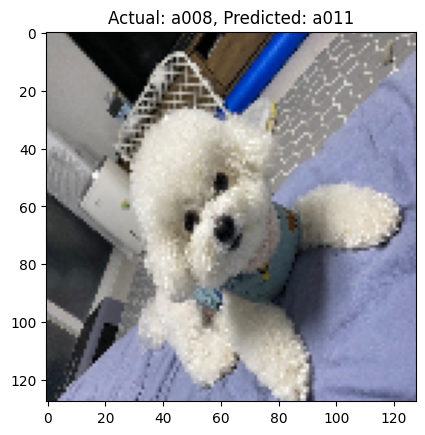

1/1 [==============================] - 0s 146ms/step


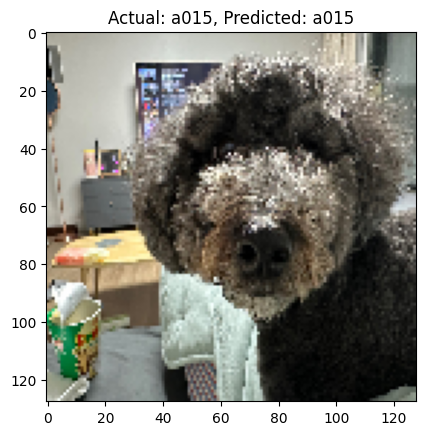

1/1 [==============================] - 0s 157ms/step


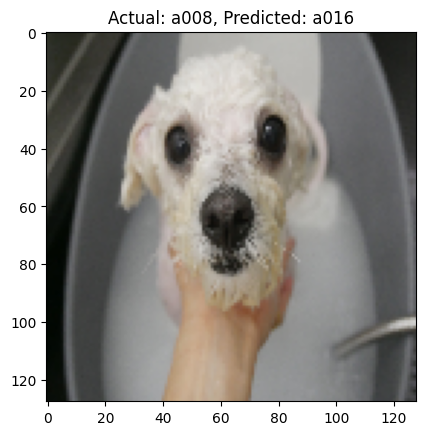

1/1 [==============================] - 0s 157ms/step


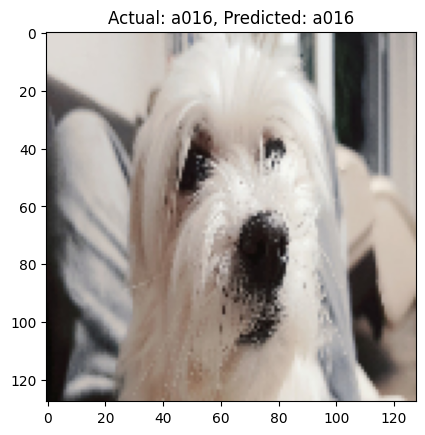

1/1 [==============================] - 0s 142ms/step


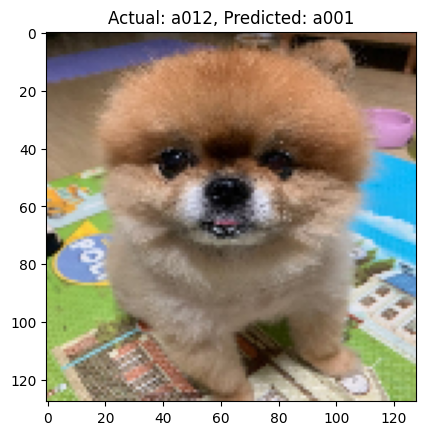

1/1 [==============================] - 0s 154ms/step


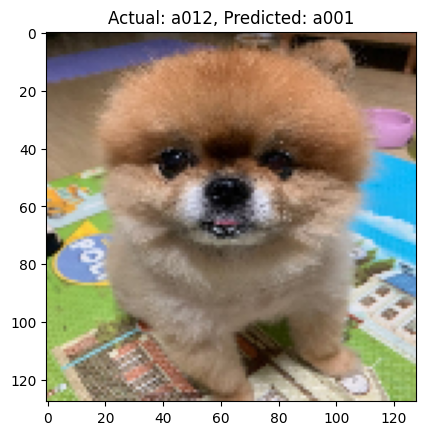

1/1 [==============================] - 0s 151ms/step


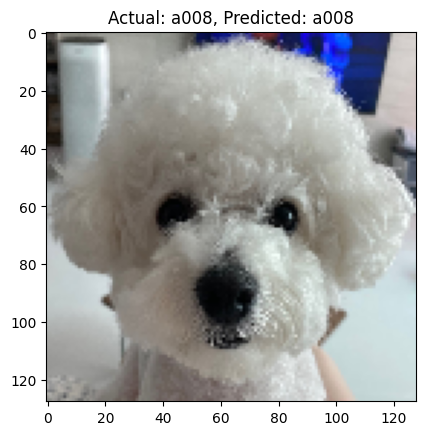

1/1 [==============================] - 0s 144ms/step


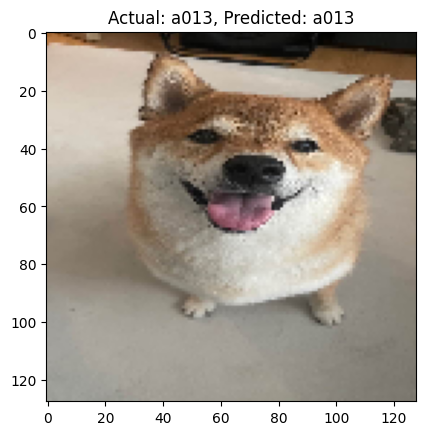

1/1 [==============================] - 0s 151ms/step


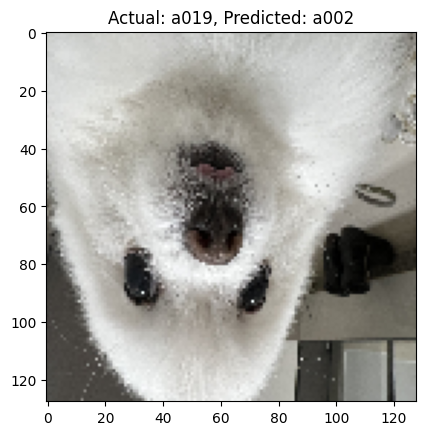

1/1 [==============================] - 0s 158ms/step


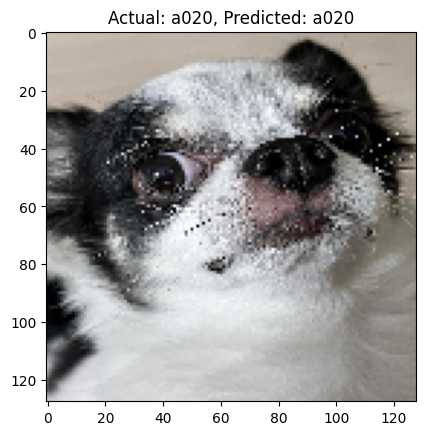

1/1 [==============================] - 0s 147ms/step


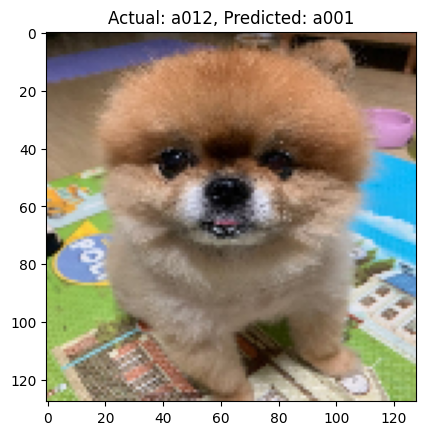

1/1 [==============================] - 0s 146ms/step


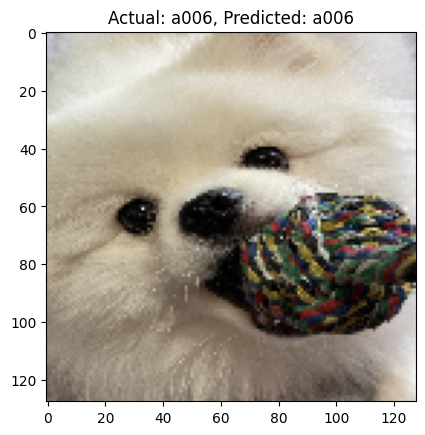

1/1 [==============================] - 0s 139ms/step


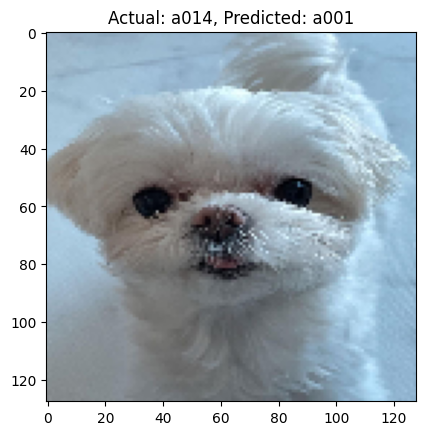

1/1 [==============================] - 0s 144ms/step


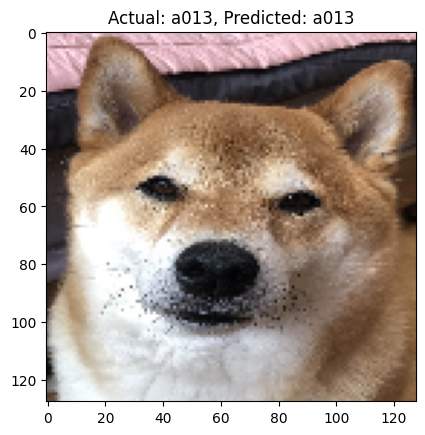

1/1 [==============================] - 0s 148ms/step


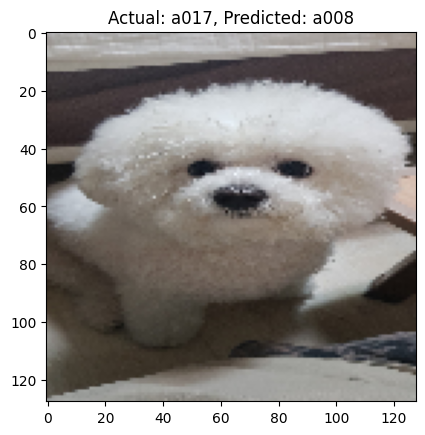

1/1 [==============================] - 0s 159ms/step


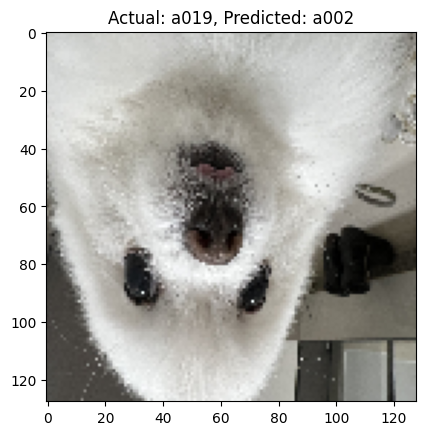

1/1 [==============================] - 0s 139ms/step


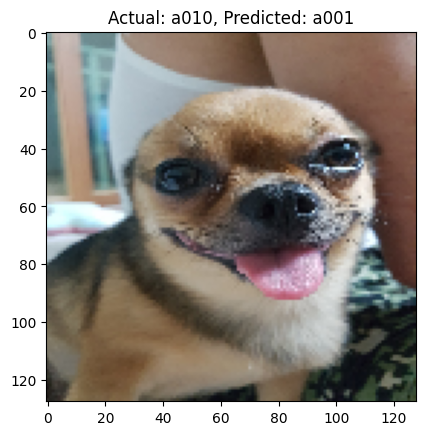

1/1 [==============================] - 0s 167ms/step


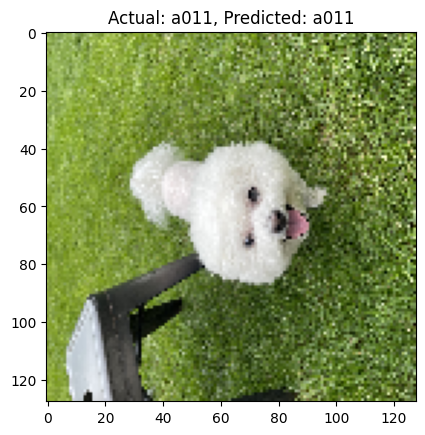

1/1 [==============================] - 0s 138ms/step


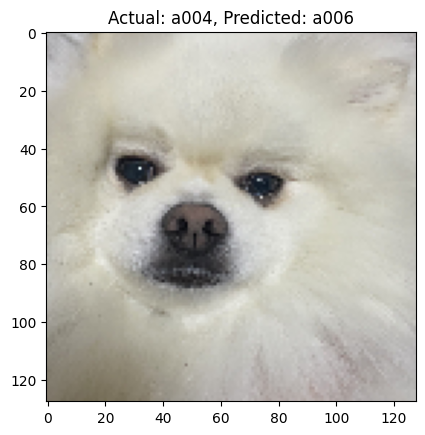

1/1 [==============================] - 0s 173ms/step


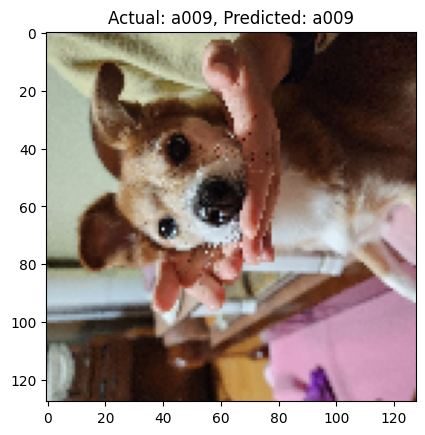

1/1 [==============================] - 0s 155ms/step


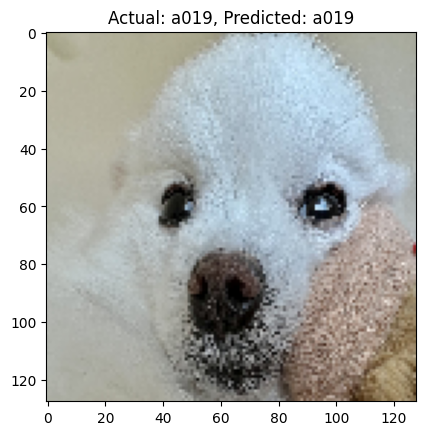

1/1 [==============================] - 0s 160ms/step


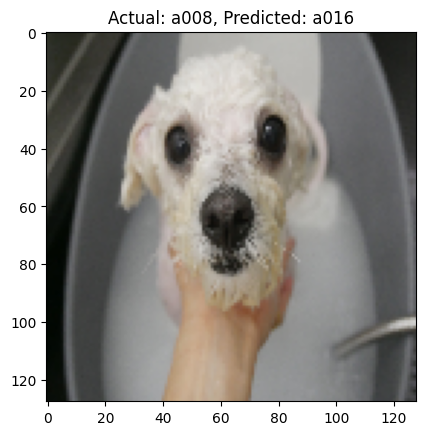

1/1 [==============================] - 0s 143ms/step


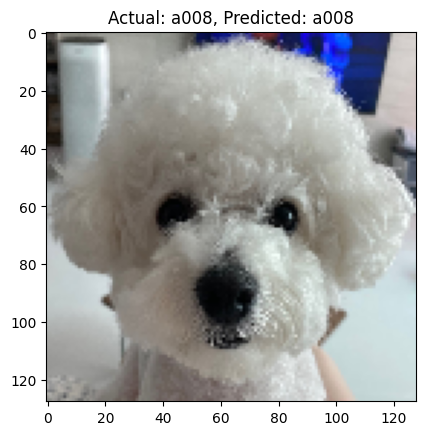

1/1 [==============================] - 0s 167ms/step


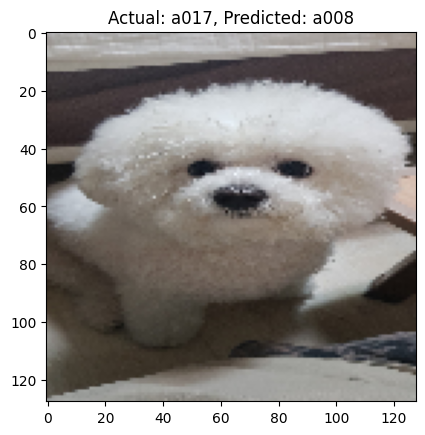

1/1 [==============================] - 0s 139ms/step


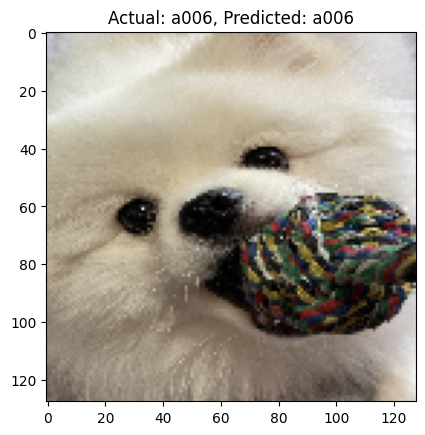

1/1 [==============================] - 0s 172ms/step


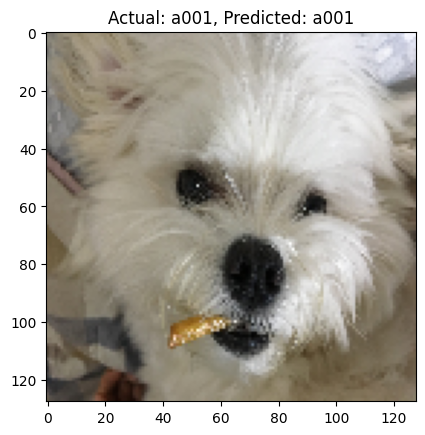

1/1 [==============================] - 0s 145ms/step


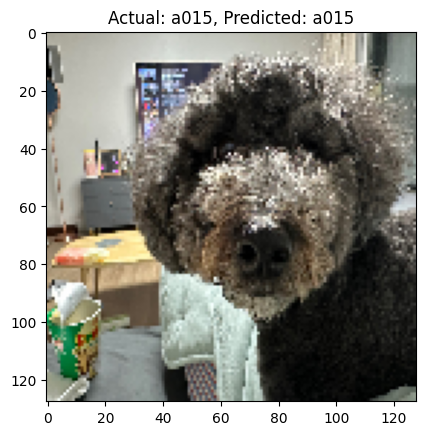

1/1 [==============================] - 0s 141ms/step


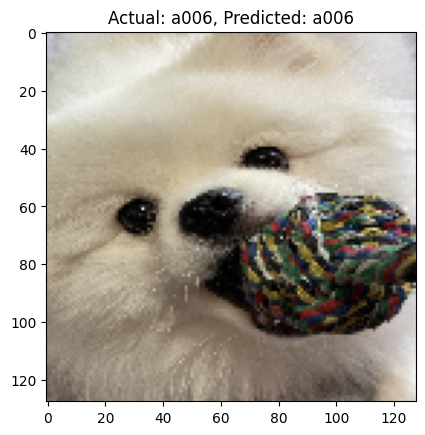

1/1 [==============================] - 0s 148ms/step


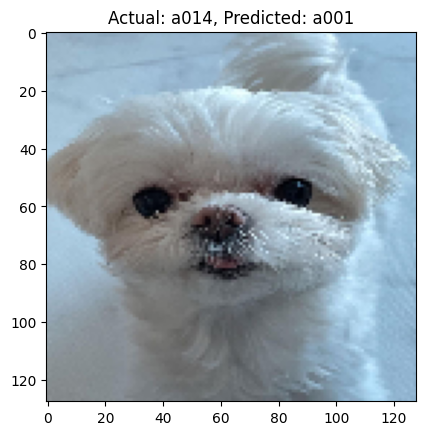

1/1 [==============================] - 0s 152ms/step


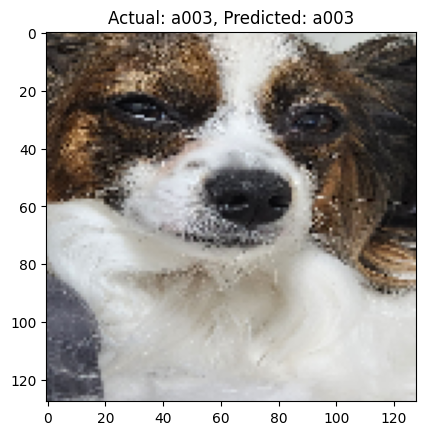

1/1 [==============================] - 0s 139ms/step


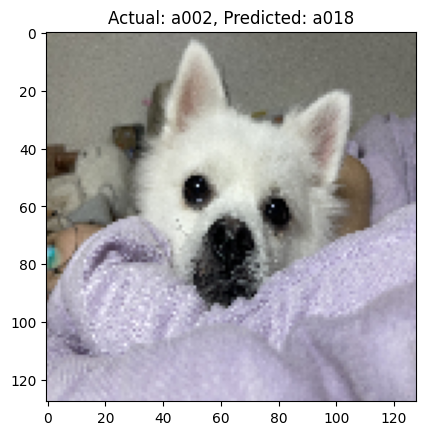

1/1 [==============================] - 0s 160ms/step


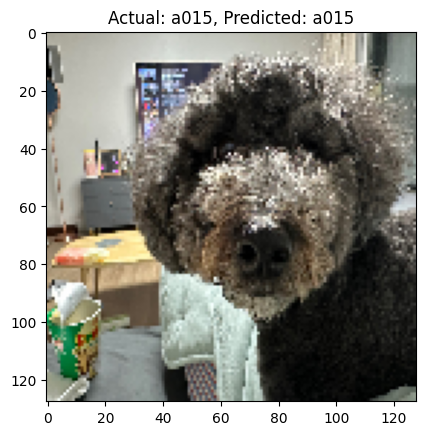

1/1 [==============================] - 0s 158ms/step


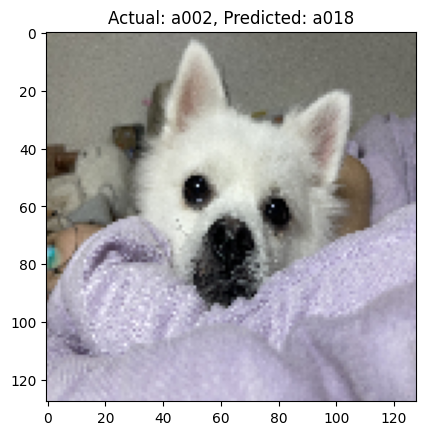

1/1 [==============================] - 0s 146ms/step


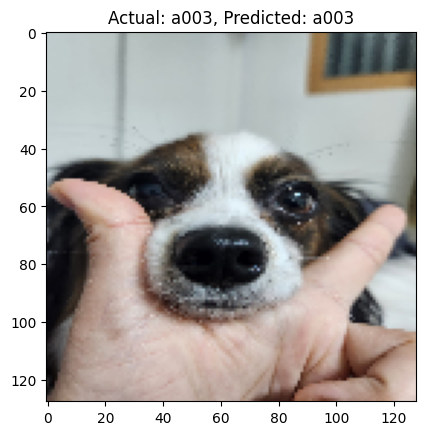

1/1 [==============================] - 0s 154ms/step


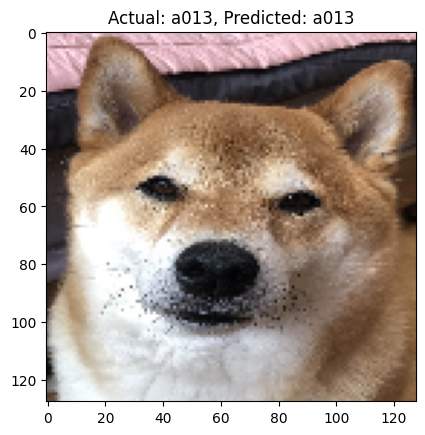

1/1 [==============================] - 0s 153ms/step


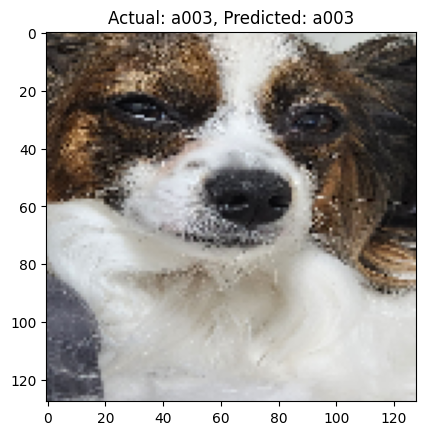

1/1 [==============================] - 0s 212ms/step


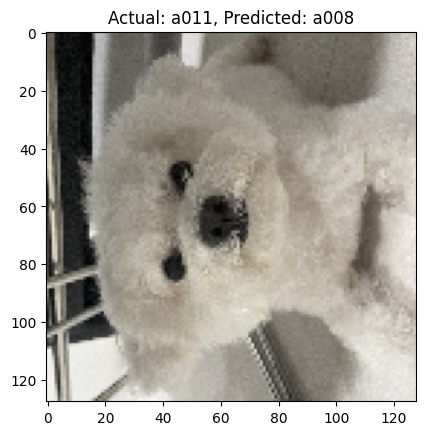

Accuracy = 0.53


In [89]:
# 예측 결과 시각화
correct_predictions = 0
total_predictions = 0
test_generator.reset()
for i in range(38):  # 이 값을 조절해서 원하는 이미지 갯수 선택 가능
    x, y = test_generator.next()
    image = x[0]
    actual_label = class_labels[np.argmax(y[0])]
    predicted_label = class_labels[np.argmax(model.predict(np.expand_dims(image, axis=0)))]
    
    if actual_label == predicted_label:
        correct_predictions += 1
    total_predictions += 1

    plt.imshow(image)
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
    plt.show()

accuracy = correct_predictions / total_predictions
print(f"Accuracy = {accuracy:.2f}")

In [90]:
model.save('ResNet_test2.h5')